In [ ]:
from tensorflow.keras.datasets import imdb
from pathlib import Path
import os
import  numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers, losses, metrics
from tensorflow.keras.preprocessing.text import Tokenizer
# text Preprocessing
import nltk
# Download the 'punkt' resource for tokenization
nltk.download('punkt')
nltk.download('punkt_tab')
# Download the 'stopwords' resource for removing stopwords
nltk.download('stopwords')
# Download the 'wordnet' resource for lemmatization
nltk.download('wordnet')
import string
import re
import html
import unicodedata
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


- Pre-Train Models
- Apply the BoW model, using three modes:

          Binary
          TF-IDF
          Frequency
          Counts

In [ ]:
# Define the path to the directory where the dataset will be stored (current directory in this case)
DATA_PATH = Path('.')

# Create the directory if it doesn't exist (if it exists, no error will be raised)
DATA_PATH.mkdir(exist_ok=True)

# Check if the dataset folder 'aclImdb' does not already exist
if not os.path.exists('./aclImdb'):
    # If the folder doesn't exist, download the IMDb sentiment dataset using curl
    !curl -O http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

    # Extract the downloaded .tar.gz file into the directory specified by DATA_PATH
    !tar -xf aclImdb_v1.tar.gz -C {DATA_PATH}

In [ ]:
# Define the two sentiment classes: 'neg' for negative reviews and 'pos' for positive reviews
CLASSES = ['neg', 'pos']
# Define the path to the IMDb dataset directory
PATH = Path('./aclImdb/')

def get_texts(path):
    # Initialize empty lists for storing texts and labels
    texts, labels = [], []

    # Loop through the sentiment classes ('neg' and 'pos')
    for idx, label in enumerate(CLASSES):
        # Loop through all the files in the directory corresponding to the class
        for fname in (path / label).glob('*.*'):  # finds all files with any extension (*.*) --> .txt
            # Read the content of each file and append to the texts list
            texts.append(fname.open('r', encoding='utf-8').read())
            # Append the corresponding label (0 for 'neg', 1 for 'pos') to the labels list
            labels.append(idx)

    # Return the lists of texts and labels
    return texts, labels

# Get texts and labels for training data (from the 'train' folder)
trn_texts, trn_labels = get_texts(PATH / 'train')

# Get texts and labels for testing data (from the 'test' folder)
tst_texts, tst_labels = get_texts(PATH / 'test')


In [ ]:
for t in trn_texts[:10]:
  print(t)

Having enjoyed Jean Arthur in "The Devil and Miss Jones", my interest was peaked, so I tried sitting through this second-string screwball outing about an investigation into the death of a jockey--but I didn't make it to the end. Arthur, photographed in a gauzy, movie-magazine fashion, either wants alimony from ex-husband William Powell or another shot at marriage, but I never felt for her because the character is just a string of wisecracks (she's the type of heroine prone to comical curiousness, but once inside a morgue--like all women in these '30's comedies--she faints). William Powell reportedly had a high time working with Miss Arthur, but you'd never know it from the end result; they look awkward standing next to each other, hesitant over their banter. The actor playing Powell's valet is excruciating, and the pauses for viewer laughs are pregnant with unease.
I really wanted to like The Pillow Book. Intriguing story, interesting character outlines, Ewan Macgregor in the utterly g

#  Text Preprocessing

In [ ]:
class TextPreprocessor:
    def __init__(self, use_stemming=False):
        # Optionally choose between stemming and lemmatization
        self.use_stemming = use_stemming
        self.stop_words = stopwords.words('english')
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()

    def remove_special_chars(self, text):
        """Remove special characters and HTML entities"""
        re1 = re.compile(r'\s{2,}')  # Multiple spaces replaced with one
        x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
            'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
            '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
            ' @-@ ', '-').replace('\\', ' \\ ')
        return re1.sub(' ', html.unescape(x1))

    def remove_non_ascii(self, text):
        """Remove non-ASCII characters"""
        return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    def to_lowercase(self, text):
        """Convert text to lowercase"""
        return text.lower()

    def remove_punctuation(self, text):
        """Remove punctuation from the text"""
        translator = str.maketrans('', '', string.punctuation)
        return text.translate(translator)

    def replace_numbers(self, text):
        """Remove digits from the text"""
        return re.sub(r'\d+', '', text)

    def remove_whitespaces(self, text):
        """Remove leading, trailing and extra whitespaces"""
        return re.sub(r'\s+', ' ', text).strip()

    def remove_stopwords(self, words):
        """Remove stopwords from tokenized text"""
        return [word for word in words if word not in self.stop_words]

    def stem_words(self, words):
        """Stem words"""
        return [self.stemmer.stem(word) for word in words]

    def lemmatize_words(self, words):
        """Lemmatize words"""
        return [self.lemmatizer.lemmatize(word) for word in words]

    def lemmatize_verbs(self, words):
        """Lemmatize verbs"""
        return [self.lemmatizer.lemmatize(word, pos='v') for word in words]

    def text2words(self, text):
        """Tokenize text into words"""
        return word_tokenize(text)

    def normalize_text(self, text):
        """Apply all preprocessing steps to normalize a single text"""
        text = self.remove_special_chars(text)
        text = self.remove_non_ascii(text)
        text = self.remove_punctuation(text)
        text = self.to_lowercase(text)
        text = self.replace_numbers(text)

        words = self.text2words(text)
        words = self.remove_stopwords(words)

        if self.use_stemming:
            words = self.stem_words(words)  # Option for stemming
        else:
            words = self.lemmatize_words(words)  # Option for lemmatization
            words = self.lemmatize_verbs(words)

        return ' '.join(words)  # Join the words properly without spacing issues

    def normalize_corpus(self, corpus):
        """Normalize an entire corpus of texts"""
        return [self.normalize_text(t) for t in corpus]


In [ ]:
# Initialize the preprocessor with stemming enabled
preprocessor = TextPreprocessor(use_stemming=True)
# Normalize the training and test data
trn_texts = preprocessor.normalize_corpus(trn_texts)
tst_texts = preprocessor.normalize_corpus(tst_texts)

 # Binary Model

In [ ]:
# Initialize the tokenizer
vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')

# Fit the tokenizer on both training and test texts
tok.fit_on_texts(trn_texts + tst_texts)

# Convert the training and test texts into binary BoW features
x_train = tok.texts_to_matrix(trn_texts, mode='binary')
x_test = tok.texts_to_matrix(tst_texts, mode='binary')

# Convert the labels into numpy arrays of type float32
y_train = np.asarray(trn_labels).astype('float32')
y_test = np.asarray(tst_labels).astype('float32')

# Optionally, check the shape of your data
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (25000, 10000)
x_test shape: (25000, 10000)
y_train shape: (25000,)
y_test shape: (25000,)


In [ ]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

# Create a Sequential model
model = Sequential()

# Add a dense layer with 16 units and ReLU activation, input size is 10000 (BoW vector size)
model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with RMSprop optimizer and binary cross-entropy loss
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),  # Learning rate of 0.001
              loss=losses.binary_crossentropy,           # Binary classification loss function
              metrics=[metrics.binary_accuracy])         # Track accuracy during training

# Train the model for 20 epochs with a batch size of 512
# Use validation data to evaluate model after each epoch
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

# Get the history of training and validation metrics
history_dict = history.history

# Check the available metrics (e.g., loss, accuracy)
history_dict.keys()


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - binary_accuracy: 0.7283 - loss: 0.5968 - val_binary_accuracy: 0.8639 - val_loss: 0.4184
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - binary_accuracy: 0.8974 - loss: 0.3537 - val_binary_accuracy: 0.8785 - val_loss: 0.3328
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - binary_accuracy: 0.9173 - loss: 0.2610 - val_binary_accuracy: 0.8792 - val_loss: 0.3100
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - binary_accuracy: 0.9324 - loss: 0.2100 - val_binary_accuracy: 0.8808 - val_loss: 0.2993
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - binary_accuracy: 0.9432 - loss: 0.1773 - val_binary_accuracy: 0.8792 - val_loss: 0.3009
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - binary_accuracy: 0.9520 - loss: 0.1509 - val_binary_accuracy: 0.8753 - val_loss: 0.3121
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - binary_accuracy: 0.9616 - loss: 0.1300 - val_binary_accuracy: 0.8753 - val_loss: 0.3255
Epoch 8/20
30

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

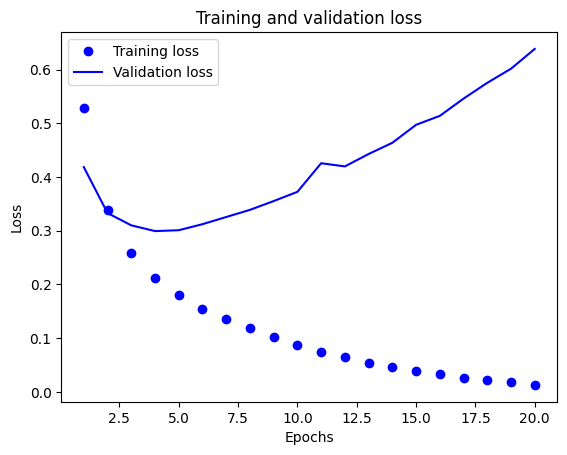

In [ ]:

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

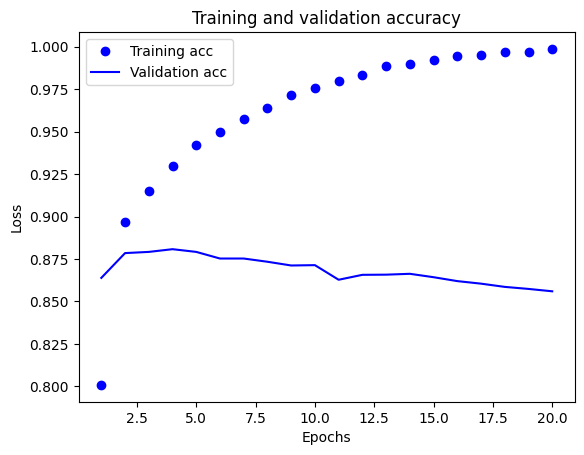

In [ ]:

plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

 # TF-IDF Model
    

In [ ]:
# Initialize the tokenizer
vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')

# Fit the tokenizer on both training and test texts
tok.fit_on_texts(trn_texts + tst_texts)

# Convert the training and test texts into tfidf BoW features
x_train = tok.texts_to_matrix(trn_texts, mode='tfidf')
x_test = tok.texts_to_matrix(tst_texts, mode='tfidf')

# Convert the labels into numpy arrays of type float32
y_train = np.asarray(trn_labels).astype('float32')
y_test = np.asarray(tst_labels).astype('float32')

# Optionally, check the shape of your data
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (25000, 10000)
x_test shape: (25000, 10000)
y_train shape: (25000,)
y_test shape: (25000,)


In [ ]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

# Create a Sequential model
model = Sequential()

# Add a dense layer with 16 units and ReLU activation, input size is 10000 (BoW vector size)
model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with RMSprop optimizer and binary cross-entropy loss
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),  # Learning rate of 0.001
              loss=losses.binary_crossentropy,           # Binary classification loss function
              metrics=[metrics.binary_accuracy])         # Track accuracy during training

# Train the model for 20 epochs with a batch size of 512
# Use validation data to evaluate model after each epoch
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

# Get the history of training and validation metrics
history_dict = history.history

# Check the available metrics (e.g., loss, accuracy)
history_dict.keys()


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - binary_accuracy: 0.7076 - loss: 0.5624 - val_binary_accuracy: 0.8534 - val_loss: 0.3745
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - binary_accuracy: 0.9187 - loss: 0.2461 - val_binary_accuracy: 0.8686 - val_loss: 0.3413
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - binary_accuracy: 0.9521 - loss: 0.1575 - val_binary_accuracy: 0.8777 - val_loss: 0.3265
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - binary_accuracy: 0.9725 - loss: 0.0992 - val_binary_accuracy: 0.8652 - val_loss: 0.3966
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - binary_accuracy: 0.9809 - loss: 0.0683 - val_binary_accuracy: 0.8612 - val_loss: 0.4699
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - binary_accuracy: 0.9887 - loss: 0.0461 - val_binary_accuracy: 0.8687 - val_loss: 0.4483
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - binary_accuracy: 0.9952 - loss: 0.0293 - val_binary_accuracy: 0.8690 - val_loss: 0.4973
Epoch 8/20
3

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

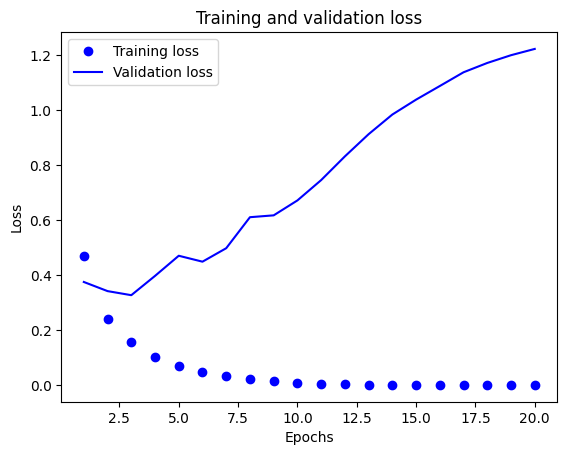

In [ ]:

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

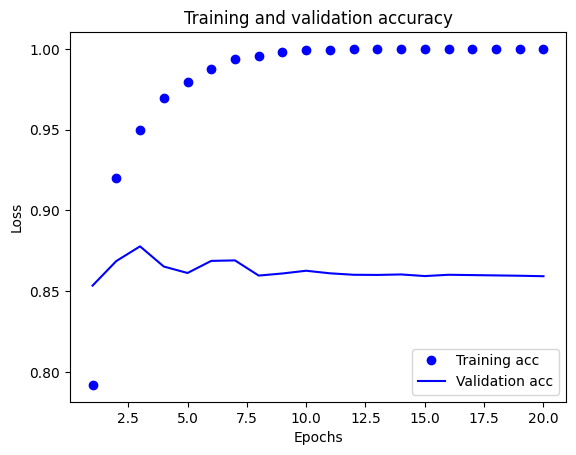

In [ ]:

plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Freq features Model






In [ ]:
# Initialize the tokenizer
vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')

# Fit the tokenizer on both training and test texts
tok.fit_on_texts(trn_texts + tst_texts)

# Convert the training and test texts into freq BoW features
x_train = tok.texts_to_matrix(trn_texts, mode='freq')
x_test = tok.texts_to_matrix(tst_texts, mode='freq')

# Convert the labels into numpy arrays of type float32
y_train = np.asarray(trn_labels).astype('float32')
y_test = np.asarray(tst_labels).astype('float32')

# Optionally, check the shape of your data
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (25000, 10000)
x_test shape: (25000, 10000)
y_train shape: (25000,)
y_test shape: (25000,)


In [ ]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

# Create a Sequential model
model = Sequential()

# Add a dense layer with 16 units and ReLU activation, input size is 10000 (BoW vector size)
model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with RMSprop optimizer and binary cross-entropy loss
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),  # Learning rate of 0.001
              loss=losses.binary_crossentropy,           # Binary classification loss function
              metrics=[metrics.binary_accuracy])         # Track accuracy during training

# Train the model for 20 epochs with a batch size of 512
# Use validation data to evaluate model after each epoch
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

# Get the history of training and validation metrics
history_dict = history.history

# Check the available metrics (e.g., loss, accuracy)
history_dict.keys()


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - binary_accuracy: 0.5063 - loss: 0.6930 - val_binary_accuracy: 0.5096 - val_loss: 0.6926
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - binary_accuracy: 0.6241 - loss: 0.6920 - val_binary_accuracy: 0.5973 - val_loss: 0.6907
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - binary_accuracy: 0.6570 - loss: 0.6903 - val_binary_accuracy: 0.7110 - val_loss: 0.6882
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - binary_accuracy: 0.6105 - loss: 0.6872 - val_binary_accuracy: 0.6099 - val_loss: 0.6846
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - binary_accuracy: 0.6517 - loss: 0.6835 - val_binary_accuracy: 0.7204 - val_loss: 0.6804
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - binary_accuracy: 0.7429 - loss: 0.6779 - val_binary_accuracy: 0.7671 - val_loss: 0.6725
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - binary_accuracy: 0.7571 - loss: 0.6702 - val_binary_accuracy: 0.7661 - val_loss: 0.6630
Epoch 8/20
30

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

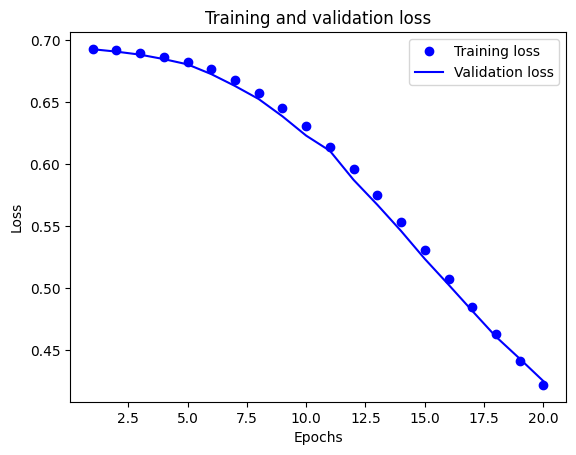

In [ ]:

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

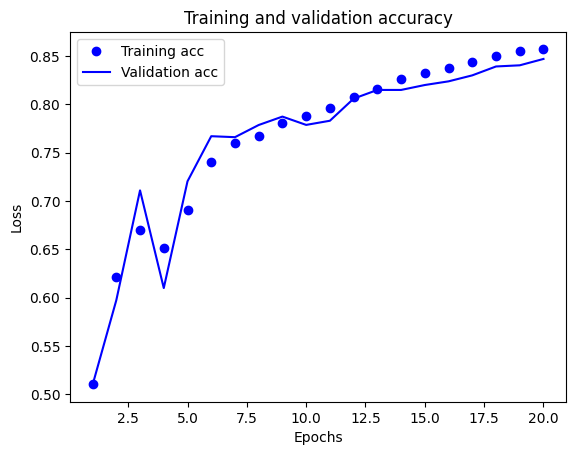

In [ ]:

plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

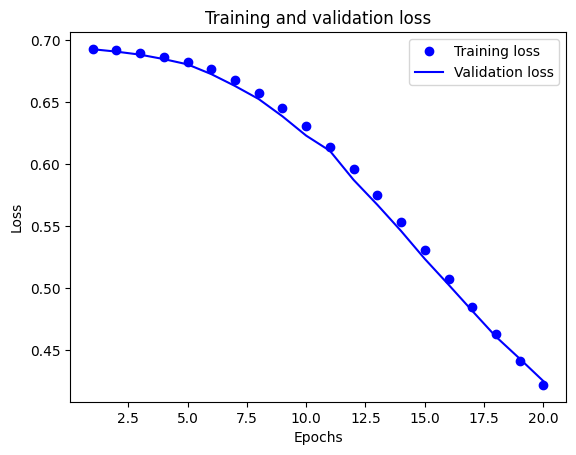

In [ ]:

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

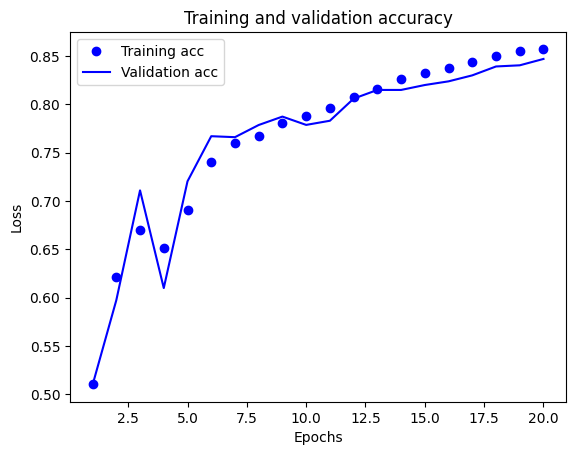

In [ ]:

plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Count Model

In [ ]:
# Initialize the tokenizer
vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')

# Fit the tokenizer on both training and test texts
tok.fit_on_texts(trn_texts + tst_texts)

# Convert the training and test texts into count BoW features
x_train = tok.texts_to_matrix(trn_texts, mode='count')
x_test = tok.texts_to_matrix(tst_texts, mode='count')

# Convert the labels into numpy arrays of type float32
y_train = np.asarray(trn_labels).astype('float32')
y_test = np.asarray(tst_labels).astype('float32')

# Optionally, check the shape of your data
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (25000, 10000)
x_test shape: (25000, 10000)
y_train shape: (25000,)
y_test shape: (25000,)


In [ ]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

# Create a Sequential model
model = Sequential()

# Add a dense layer with 16 units and ReLU activation, input size is 10000 (BoW vector size)
model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with RMSprop optimizer and binary cross-entropy loss
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),  # Learning rate of 0.001
              loss=losses.binary_crossentropy,           # Binary classification loss function
              metrics=[metrics.binary_accuracy])         # Track accuracy during training

# Train the model for 20 epochs with a batch size of 512
# Use validation data to evaluate model after each epoch
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

# Get the history of training and validation metrics
history_dict = history.history

# Check the available metrics (e.g., loss, accuracy)
history_dict.keys()


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - binary_accuracy: 0.6985 - loss: 0.5914 - val_binary_accuracy: 0.8703 - val_loss: 0.3838
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - binary_accuracy: 0.9023 - loss: 0.3182 - val_binary_accuracy: 0.8796 - val_loss: 0.3270
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - binary_accuracy: 0.9231 - loss: 0.2381 - val_binary_accuracy: 0.8806 - val_loss: 0.3100
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - binary_accuracy: 0.9370 - loss: 0.1953 - val_binary_accuracy: 0.8798 - val_loss: 0.3142
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - binary_accuracy: 0.9479 - loss: 0.1621 - val_binary_accuracy: 0.8796 - val_loss: 0.3152
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - binary_accuracy: 0.9541 - loss: 0.1450 - val_binary_accuracy: 0.8760 - val_loss: 0.3435
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - binary_accuracy: 0.9629 - loss: 0.1242 - val_binary_accuracy: 0.8733 - val_loss: 0.3578
Epoch 8/20
30

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

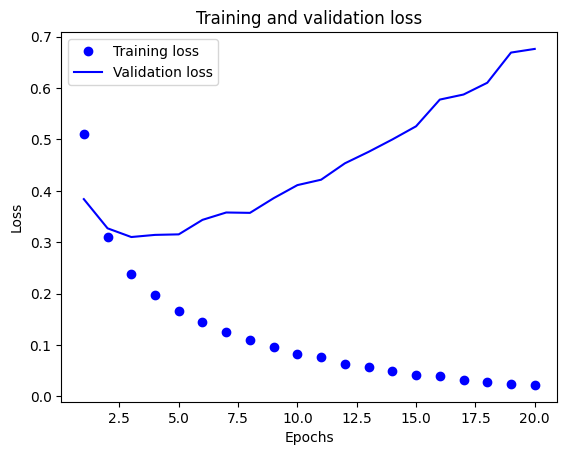

In [ ]:

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

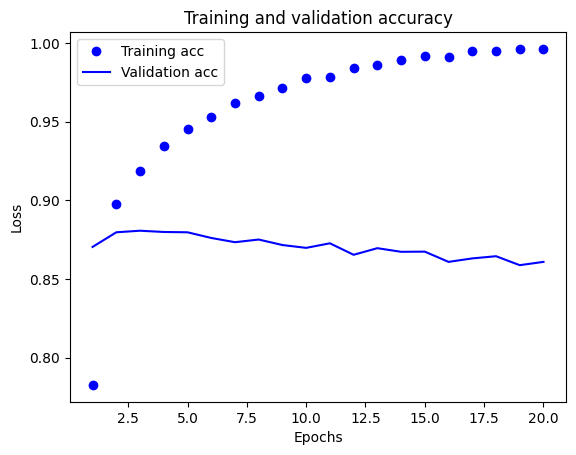

In [ ]:

plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()